### Importing Necessary Libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing & Opening the data 

In [3]:
# Load the dataset
netcdf_file_path = "Data/model_IO/final_SSC_Data.nc"

# Open the data using xarray
dataset = xr.open_dataset(netcdf_file_path)

### Converting Dataframe to Pandas and Dropping uneccessary Columns

In [4]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

df

,time,lat,lon,u,v
0,2020-02-25 15:00:00,35.744701,13.6768,NaN,NaN
1,2020-02-25 15:00:00,35.744701,13.7174,NaN,NaN
2,2020-02-25 15:00:00,35.744701,13.7579,NaN,NaN
3,2020-02-25 15:00:00,35.744701,13.7985,NaN,NaN
4,2020-02-25 15:00:00,35.744701,13.8390,NaN,NaN
...,...,...,...,...,...
60892983,2023-08-01 23:00:00,36.880199,15.2182,NaN,NaN
60892984,2023-08-01 23:00:00,36.880199,15.2587,NaN,NaN
60892985,2023-08-01 23:00:00,36.880199,15.2993,NaN,NaN
60892986,2023-08-01 23:00:00,36.880199,15.3398,NaN,NaN


### Filtering Dataframe by specific pair of coordinates & applying Spline Interpolation to NaNs

In [5]:
# Define target latitude and longitude for data filtering.
target_lat = 36.03409957885742
target_lon = 14.528599739074707

# Filter the DataFrame to only include data for the specified coordinates.
df = df[(df['lat'] == target_lat) & (df['lon'] == target_lon)]

# Ensure the DataFrame is sorted by time
df.sort_index(inplace=True)

# Drop rows where either 'u' or 'v' (or both) have NaN values
df.dropna(subset=['u', 'v'], inplace=True)

df

C:\Users\markd\AppData\Local\Temp\ipykernel_10200\1160317032.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['u', 'v'], inplace=True)


,time,lat,lon,u,v
580,2020-02-25 15:00:00,36.0341,14.5286,0.142856,-0.085644
2816,2020-02-25 16:00:00,36.0341,14.5286,0.133010,-0.018187
5052,2020-02-25 17:00:00,36.0341,14.5286,0.096112,0.009815
7288,2020-02-25 18:00:00,36.0341,14.5286,0.075022,0.004789
9524,2020-02-25 19:00:00,36.0341,14.5286,0.039128,0.012974
...,...,...,...,...,...
60882388,2023-08-01 19:00:00,36.0341,14.5286,0.140230,-0.185754
60884624,2023-08-01 20:00:00,36.0341,14.5286,0.113880,-0.225836
60886860,2023-08-01 21:00:00,36.0341,14.5286,0.101888,-0.212993
60889096,2023-08-01 22:00:00,36.0341,14.5286,0.108439,-0.201915


### Converting the 'time' column to datetime format & setting it as the index

In [6]:
df[['time', 'u', 'v']]

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

# Set the 'time' column as the index of the DataFrame
df.set_index('time')['u']

C:\Users\markd\AppData\Local\Temp\ipykernel_10200\1220816150.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
C:\Users\markd\AppData\Local\Temp\ipykernel_10200\1220816150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


time
2020-02-25 15:00:00    0.142856
2020-02-25 16:00:00    0.133010
2020-02-25 17:00:00    0.096112
2020-02-25 18:00:00    0.075022
2020-02-25 19:00:00    0.039128
                         ...   
2023-08-01 19:00:00    0.140230
2023-08-01 20:00:00    0.113880
2023-08-01 21:00:00    0.101888
2023-08-01 22:00:00    0.108439
2023-08-01 23:00:00    0.182186
Name: u, Length: 14282, dtype: float64

### Plotting the 'u' and 'v' 

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

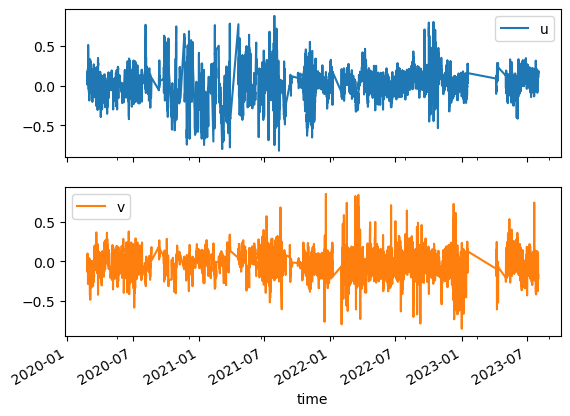

In [7]:
# Plot 'u' and 'v' columns over time
df.set_index('time')[['u', 'v']].plot(subplots=True)

### Preparing the input features

In [8]:
# Select 'u' and 'v' columns as input features
df_input = df[['u', 'v']]
df_input

,u,v
580,0.142856,-0.085644
2816,0.133010,-0.018187
5052,0.096112,0.009815
7288,0.075022,0.004789
9524,0.039128,0.012974
...,...,...
60882388,0.140230,-0.185754
60884624,0.113880,-0.225836
60886860,0.101888,-0.212993
60889096,0.108439,-0.201915


### Saving as features & setting the targets

In [9]:
# Save data as features for model input
features = df_input.to_numpy()

# Set the first column as the target variable
target = df_input['u'].values   

### Splitting Data in Train & Test splits

In [10]:
# First, split into training (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)

# Then, split the temp set into validation and test sets (50% each of 30% => 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, shuffle=False)

# Check the shape of each set
X_train.shape, X_val.shape, X_test.shape

((9997, 2), (2142, 2), (2143, 2))

### Creating batches of time series data 

In [11]:
win_length = 168 # 7 days
batch_size = 64
num_features = 2

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[ 0.14285568, -0.08564356],
         [ 0.1330104 , -0.01818698],
         [ 0.09611177,  0.00981483],
         ...,
         [ 0.21620987, -0.12809769],
         [ 0.2863795 , -0.15603455],
         [ 0.28766638, -0.19435467]],
 
        [[ 0.1330104 , -0.01818698],
         [ 0.09611177,  0.00981483],
         [ 0.0750224 ,  0.00478938],
         ...,
         [ 0.2863795 , -0.15603455],
         [ 0.28766638, -0.19435467],
         [ 0.30652724, -0.21733847]],
 
        [[ 0.09611177,  0.00981483],
         [ 0.0750224 ,  0.00478938],
         [ 0.03912837,  0.01297434],
         ...,
         [ 0.28766638, -0.19435467],
         [ 0.30652724, -0.21733847],
         [ 0.27304935, -0.25024555]],
 
        ...,
 
        [[-0.00780175, -0.03144679],
         [ 0.03161206, -0.06657679],
         [ 0.03218285, -0.12196775],
         ...,
         [-0.00623628, -0.0983379 ],
         [ 0.02299714, -0.08629904],
         [ 0.04721662, -0.0990007 ]],
 
        [[ 0.03161206, -0.066

### Constructing the LSTM Model

In [12]:
model = Sequential([
    LSTM(256, input_shape=(win_length, num_features), return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 256)          265216    
                                                                 
 dropout (Dropout)           (None, 168, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 168, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 168, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 168, 128)          131584    
                                                                 
 dropout_2 (Dropout)         (None, 168, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                

### Training the Model

In [13]:
# Set up early stopping 
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=8, 
                               mode='min',
                               restore_best_weights=True)

# Compile the model 
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.001),
              metrics=[MeanAbsoluteError()])

# Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_test_model",
                                   save_best_only=True,
                                   monitor='val_loss',  
                                   mode='min',
                                   verbose=0)  

# Fit the model to
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    shuffle=False,
                    callbacks=[early_stopping, model_checkpoint])

# Determine the epoch number at best performance
best_epoch = early_stopping.stopped_epoch - early_stopping.patience

print(f"="*175)
print(f"Training stopped at epoch: {best_epoch + 1}")
print(f"Best validation loss achieved at epoch: {best_epoch + 1}")

Epoch 1/100

154/154 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.1166INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 137s 840ms/step - loss: 0.0265 - mean_absolute_error: 0.1166 - val_loss: 0.0190 - val_mean_absolute_error: 0.0982
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.0252 - mean_absolute_error: 0.1146INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 139s 902ms/step - loss: 0.0252 - mean_absolute_error: 0.1146 - val_loss: 0.0182 - val_mean_absolute_error: 0.0957
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.1099INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 150s 975ms/step - loss: 0.0239 - mean_absolute_error: 0.1099 - val_loss: 0.0151 - val_mean_absolute_error: 0.0859
Epoch 4/100
154/154 [==============================] - ETA: 0s - loss: 0.0208 - mean_absolute_error: 0.1006INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 189s 1s/step - loss: 0.0208 - mean_absolute_error: 0.1006 - val_loss: 0.0123 - val_mean_absolute_error: 0.0748
Epoch 5/100
154/154 [==============================] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.0838INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 213s 1s/step - loss: 0.0154 - mean_absolute_error: 0.0838 - val_loss: 0.0099 - val_mean_absolute_error: 0.0636
Epoch 6/100
154/154 [==============================] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0738INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 209s 1s/step - loss: 0.0128 - mean_absolute_error: 0.0738 - val_loss: 0.0083 - val_mean_absolute_error: 0.0552
Epoch 7/100
154/154 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0676INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 227s 1s/step - loss: 0.0114 - mean_absolute_error: 0.0676 - val_loss: 0.0078 - val_mean_absolute_error: 0.0536
Epoch 8/100
154/154 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0656INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 227s 1s/step - loss: 0.0109 - mean_absolute_error: 0.0656 - val_loss: 0.0075 - val_mean_absolute_error: 0.0510
Epoch 9/100
154/154 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0647INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 221s 1s/step - loss: 0.0106 - mean_absolute_error: 0.0647 - val_loss: 0.0072 - val_mean_absolute_error: 0.0500
Epoch 10/100
154/154 [==============================] - 214s 1s/step - loss: 0.0104 - mean_absolute_error: 0.0635 - val_loss: 0.0073 - val_mean_absolute_error: 0.0504
Epoch 11/100
154/154 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0625INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 225s 1s/step - loss: 0.0102 - mean_absolute_error: 0.0625 - val_loss: 0.0072 - val_mean_absolute_error: 0.0499
Epoch 12/100
154/154 [==============================] - 194s 1s/step - loss: 0.0104 - mean_absolute_error: 0.0632 - val_loss: 0.0075 - val_mean_absolute_error: 0.0518
Epoch 13/100
154/154 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0637INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 204s 1s/step - loss: 0.0104 - mean_absolute_error: 0.0637 - val_loss: 0.0072 - val_mean_absolute_error: 0.0498
Epoch 14/100
154/154 [==============================] - 178s 1s/step - loss: 0.0106 - mean_absolute_error: 0.0641 - val_loss: 0.0072 - val_mean_absolute_error: 0.0493
Epoch 15/100
154/154 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0631INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


154/154 [==============================] - 192s 1s/step - loss: 0.0104 - mean_absolute_error: 0.0631 - val_loss: 0.0070 - val_mean_absolute_error: 0.0482
Epoch 16/100
154/154 [==============================] - 196s 1s/step - loss: 0.0105 - mean_absolute_error: 0.0635 - val_loss: 0.0073 - val_mean_absolute_error: 0.0505
Epoch 17/100
154/154 [==============================] - 205s 1s/step - loss: 0.0105 - mean_absolute_error: 0.0637 - val_loss: 0.0071 - val_mean_absolute_error: 0.0490
Epoch 18/100
154/154 [==============================] - 191s 1s/step - loss: 0.0103 - mean_absolute_error: 0.0629 - val_loss: 0.0073 - val_mean_absolute_error: 0.0507
Epoch 19/100
154/154 [==============================] - 191s 1s/step - loss: 0.0105 - mean_absolute_error: 0.0638 - val_loss: 0.0072 - val_mean_absolute_error: 0.0499
Epoch 20/100
154/154 [==============================] - 192s 1s/step - loss: 0.0103 - mean_absolute_error: 0.0629 - val_loss: 0.0075 - val_mean_absolute_error: 0.0517
Epoch 21/10

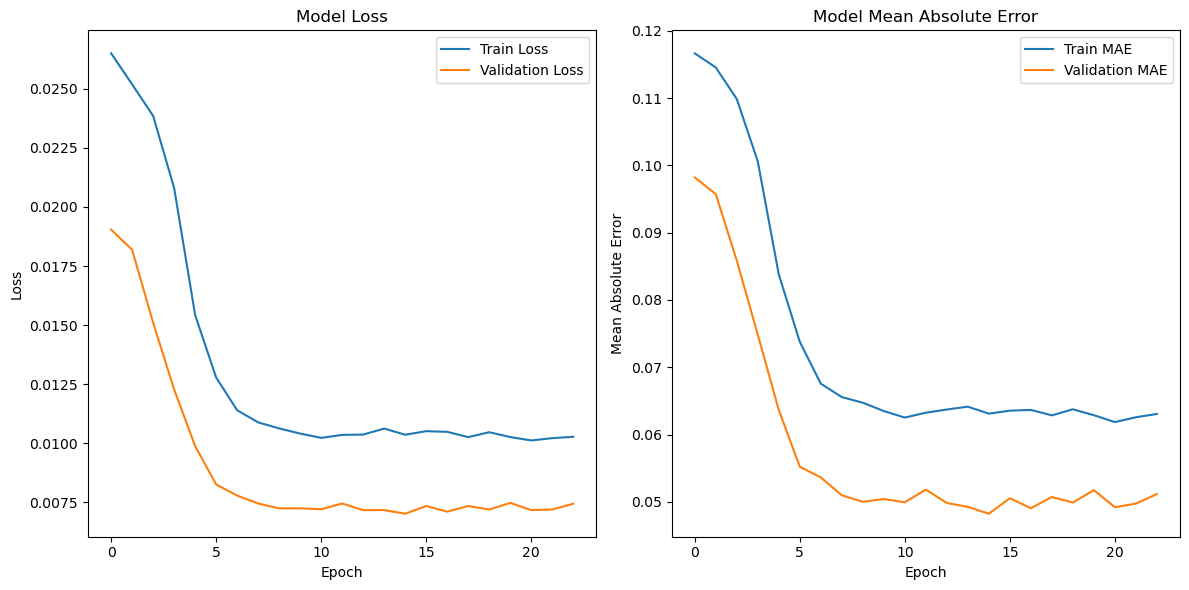

In [14]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Making predictions & evaluating from the Test set

In [15]:
# Generate predictions for the test data
predictions = model.predict(test_generator)

31/31 [==============================] - 12s 329ms/step


### Preparing the final DataFrame for plotting and analysis

In [16]:
df_final = df_input.iloc[-len(predictions):].copy()

df_final['u_pred'] = predictions.flatten()

df_final

,u,v,u_pred
56282936,0.074616,0.023952,0.031069
56285172,0.014319,0.000936,0.072828
56287408,-0.014228,0.037096,0.011900
56289644,-0.014253,0.038269,-0.010444
56291880,-0.005687,0.061540,-0.009869
...,...,...,...
60882388,0.140230,-0.185754,0.117909
60884624,0.113880,-0.225836,0.118289
60886860,0.101888,-0.212993,0.094339
60889096,0.108439,-0.201915,0.078272


In [17]:
# Actual and predicted 'u' values
y_true = df_final['u'].values
y_pred = df_final['u_pred'].values

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Print out the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 0.0024138307293753805
Mean Absolute Error (MAE): 0.03662414442021205
Root Mean Squared Error (RMSE): 0.04913075136180375


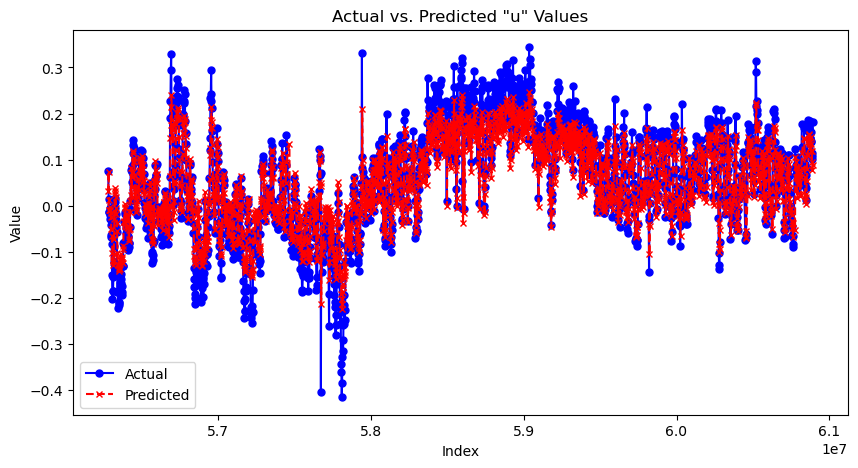

In [18]:
plt.figure(figsize=(10, 5))  
plt.plot(df_final.index, df_final['u'], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(df_final.index, df_final['u_pred'], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
plt.title('Actual vs. Predicted "u" Values')  
plt.xlabel('Index') 
plt.ylabel('Value')  
plt.legend() 
plt.show() 

### Making a real life Rolling Prediction

In [21]:
# Number of hours to predict into the future
n_future_hours = 24

# Path to the NetCDF file containing input data from August 1, 2023 till august 3, 2023
# input_data_path = "Data/model_IO/3_day_input_SSC_Data.nc"
input_data_path = "Data/1_week_SSC_Data.nc"

# Load the dataset
input_dataset = xr.open_dataset(input_data_path)

# Select data for the target latitude and longitude
input_data = input_dataset.sel(lat=target_lat, lon=target_lon, method='nearest').to_dataframe().reset_index()

# Ensure the DataFrame is sorted by time (if not already)
input_data.sort_values('time', inplace=True)

# Interpolate NaN values using cubic spline interpolation
input_data[['u', 'v']] = input_data[['u', 'v']].interpolate(method='spline', order=3)

# After interpolation, if there are still NaNs at the beginning or the end, fill them with the first/last valid value
input_data[['u', 'v']] = input_data[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

# Select and preprocess the required features
features = input_data[['u', 'v']].values

# Check if the number of samples is less than the desired window length
if len(features) < win_length:
    raise ValueError("Not enough samples in the input data to match the desired window length.")

# Reshape data to match the input shape expected by the LSTM model
last_24_hours_features = features[-win_length:].reshape(1, win_length, num_features)

# Initialize the array to store predictions
predictions_u = []

# Make predictions for each hour
for i in range(n_future_hours):
    # Predict the next step
    current_prediction_u = model.predict(last_24_hours_features, verbose=0)[0, 0]
    
    # Append the prediction to the predictions list
    predictions_u.append(current_prediction_u)
    
    # Update the last 24 hours for the next prediction, incorporating actual 'v' values
    # Extract the next set of 'v' values from the input features, ensuring continuity
    next_v_values = features[i + 1:min(i + win_length, len(features)), 1] if i + 1 < len(features) else features[-win_length:, 1]
    
    # Update 'u' with the current prediction and 'v' with the next set of actual values
    updated_features = np.column_stack((
        np.append(last_24_hours_features[0, 1:, 0], current_prediction_u),  # Update 'u' values
        np.append(next_v_values, np.full((win_length - len(next_v_values),), next_v_values[-1]))  # Update 'v' values, fill if necessary
    ))
    
    # Reshape for the next prediction
    last_24_hours_features = updated_features.reshape(1, win_length, num_features)

In [ ]:
# Load the actual data equivalent to the next day (August 4th, 2023)
# actual_data_nc = xr.open_dataset('Data/model_IO/1_day_actual_4th_SSC_Data.nc')
actual_data_nc = xr.open_dataset('Data/1_day_SSC_Data.nc')

# Convert to DataFrame and filter based on selected latitude and longitude
actual_data_df = actual_data_nc.sel(lat=target_lat, lon=target_lon, method='nearest').to_dataframe().reset_index()

# Ensure the DataFrame is sorted by time
actual_data_df.sort_values('time', inplace=True) 

# Clean up the DataFrame by dropping unnecessary columns
actual_data_df = actual_data_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Remove NaN values from the DataFrame
actual_data_df.dropna(inplace=True)

# Extract 'u' values from the actual data
actual_u_values = actual_data_df['u'].values

# Ensure that the actual data and predictions have the same length
trimmed_predictions_u = predictions_u[:len(actual_u_values)]

# Calculate evaluation metrics using the trimmed predictions
mae = mean_absolute_error(actual_u_values, trimmed_predictions_u)
mse = mean_squared_error(actual_u_values, trimmed_predictions_u)
rmse = np.sqrt(mse)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Create a DataFrame to store actual and predicted values for comparison
comparison_df = pd.DataFrame({
    'Time': actual_data_df['time'],
    'Actual_u': actual_u_values,
    'Predicted_u': trimmed_predictions_u
})

# Display the DataFrame for review
comparison_df